In [12]:
import os
import datetime
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
#import shap

import sys
sys.path.append('/home/rluser/thesis_ws/src/ML/UTILITIES')
from PreProcessingFunctions import myfilter, num_transient, sliding_sum_window, select_index, add_padding
from PreProcessingFunctions import WS
from PreProcessingFunctions import rename_and_convert_to_txt

from OrganizeReports import compare_and_organize
from Performance_plotter import plot_f1_score_threshold, plot_precision_recall_curve, plot_confusion_matrix, plot_roc_curve
from ML_models_functions import to_save_model, free_gpu_memory

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score, classification_report

import tensorflow
gpus = tensorflow.config.list_physical_devices('GPU')
if gpus:    
    for gpu in gpus:
        tensorflow.config.set_logical_device_configuration(
            gpu,
            [tensorflow.config.LogicalDeviceConfiguration(memory_limit=4*1024)])  # Adjust memory limit as needed


from tensorflow.keras.models     import Sequential, Model, load_model
from tensorflow.keras.layers     import Input, Conv1D, Conv2D, BatchNormalization
from tensorflow.keras.layers     import Flatten, Dense, MaxPooling1D, MaxPooling2D, GlobalMaxPooling1D
from tensorflow.keras.layers     import LeakyReLU, ReLU, Activation, Dropout, Lambda
from tensorflow.keras.layers     import concatenate, Concatenate
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.losses     import binary_crossentropy, categorical_crossentropy
from tensorflow.keras.metrics    import AUC, Precision, Recall
from tensorflow.keras.callbacks  import EarlyStopping

from tensorflow.keras.utils      import plot_model

data_folder = '/home/rluser/thesis_ws/src/ML_ACTIONS/DATA/1D_LDG_F_ScalNorm'

def load_data(data_folder):
    X_data = []
    y_data = []
    # Get list of all .npz files in the data folder
    npz_files = [file for file in os.listdir(data_folder) if file.endswith('.npz')]
    
    # Load data from each .npz file
    for file in npz_files:
        file_path = os.path.join(data_folder, file)
        data = np.load(file_path)
        X_data.append(data['X'])  # Assuming X_data is stored under 'X' key in the .npz file
        y_data.append(data['y'])  # Assuming y_data is stored under 'y' key in the .npz file
        data.close()
    
    # Convert lists to NumPy arrays
    X_data = np.array(X_data)
    y_data = np.array(y_data)
    
    return X_data, y_data

# Load the data
X_data, y_data = load_data(data_folder)

# Check the shape of loaded data
print("X_data shape:", X_data.shape)
print("y_data shape:", y_data.shape)
print("X_data.[0] shape: ", X_data[0].shape)

TEST_SIZE = 0.4
X_train, X_temp, y_train, y_temp = train_test_split(X_data, y_data, test_size=TEST_SIZE, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"TOTAL DATA: {len(X_data)}  ||  Train = {100*(1-TEST_SIZE)}%  ||  Test = {100*TEST_SIZE}%")
print("Dimensions of X_train:", X_train.shape, "   ||  Dimensions of y_train:", y_train.shape)
print("Dimensions of X_test: ", X_test.shape, "   ||  Dimensions of y_test: ", y_test.shape)
print("Dimensions of X_val:  ", X_val.shape, "   ||  Dimensions of y_val:  ", y_val.shape)

WS_B = 3000
N_CLASS = 4
DISP_LABELS = ["0", "1", "2", "3"]

X_data shape: (430, 3000)
y_data shape: (430,)
X_data.[0] shape:  (3000,)
TOTAL DATA: 430  ||  Train = 60.0%  ||  Test = 40.0%
Dimensions of X_train: (258, 3000)    ||  Dimensions of y_train: (258,)
Dimensions of X_test:  (86, 3000)    ||  Dimensions of y_test:  (86,)
Dimensions of X_val:   (86, 3000)    ||  Dimensions of y_val:   (86,)


# 1 CONVs

/home/rluser/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_21 (Conv1D)              │ (None, 297, 64)        │         2,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_18 (MaxPooling1D) │ (None, 148, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 9472)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │       606,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 609,156 (2.32 MB)

 Trainable params: 609,156 (2.32 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/22
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.4684 - loss: 1.0544 - val_accuracy: 0.7442 - val_loss: 0.5786
Epoch 2/22
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7584 - loss: 0.5384 - val_accuracy: 0.7558 - val_loss: 0.6135
Epoch 3/22
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7525 - loss: 0.5674 - val_accuracy: 0.7791 - val_loss: 0.3636
Epoch 4/22
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8327 - loss: 0.3827 - val_accuracy: 0.8372 - val_loss: 0.4170
Epoch 5/22
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8104 - loss: 0.4723 - val_accuracy: 0.8605 - val_loss: 0.3402
Epoch 6/22
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8749 - loss: 0.3268 - val_accuracy: 0.8256 - val_loss: 0.3522
Epoch 7/22
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8452 - loss: 0.3304 - val_accuracy: 0.8488 - val_loss: 0.4057
Epoch 8/22
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8886 - loss: 0.3059 - val_accuracy: 0.8140 - val_loss: 0.3251
Epoch 9

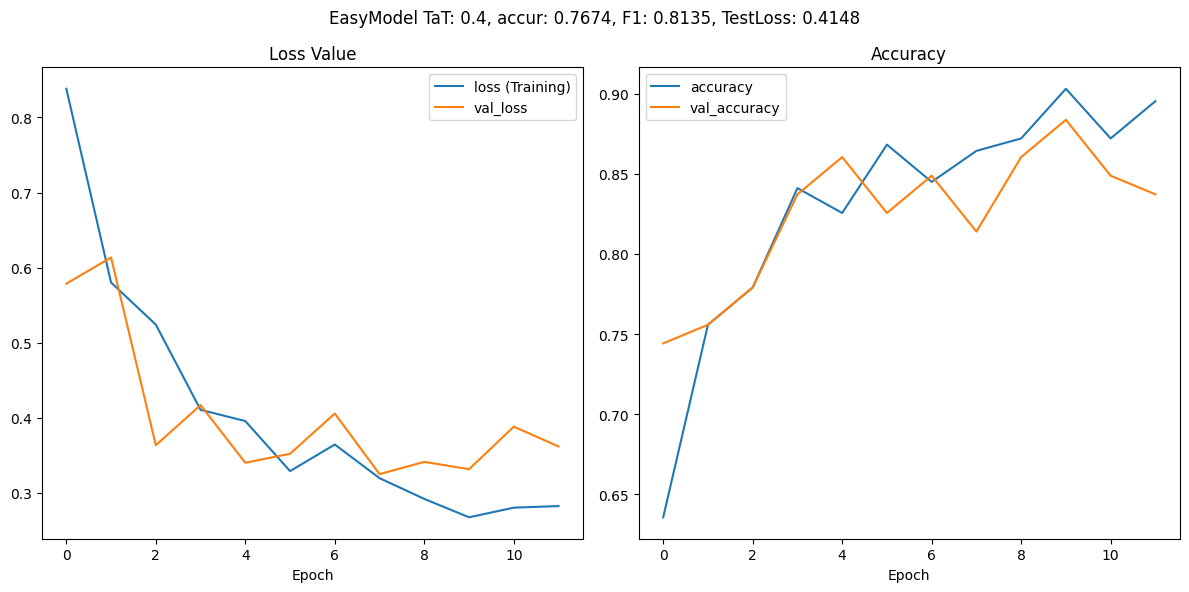

Train loss: 0.2825506031513214
Test val_loss: 0.3619437515735626
Train accuracy: 0.895348846912384
Accuracy Score: 0.7674418604651163
F1 Score: 0.8135294117647058
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        18
         1.0       1.00      0.92      0.96        13
         2.0       0.61      0.74      0.67        27
         3.0       0.70      0.57      0.63        28

    accuracy                           0.77        86
   macro avg       0.83      0.81      0.81        86
weighted avg       0.78      0.77      0.77        86



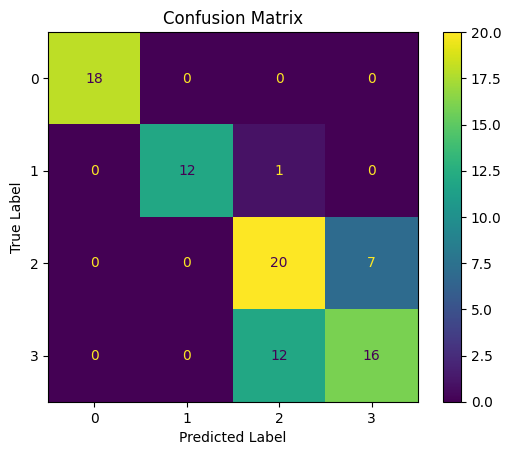

In [13]:
def build_easyModel():
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=40, strides=10, activation='relu', input_shape=(WS_B, 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    #model.add(GlobalMaxPooling1D())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(N_CLASS, activation='softmax'))
    return model

model_name = "1D_easy1Conv"
model = build_easyModel()
model.summary()
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#TRAIN THE MODEL
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=32, batch_size=32, validation_data=(X_val, y_val), verbose=1, callbacks=[early_stopping])

loss, accuracy = model.evaluate(X_test, y_test)

# Predict labels for test data
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1) 

f1 = f1_score(y_test, y_pred_labels, average='macro') 
accuracy = accuracy_score(y_test, y_pred_labels)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()

# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_labels))

conf_mat = confusion_matrix(y_test, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=DISP_LABELS)
disp.plot()  # You can adjust the colormap as needed
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# <span style="color:red;"> PLOT F1 SCORE AND F1 WRT ALL the THRESHOLDS</span>


# 2 CONVs 

/home/rluser/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_22 (Conv1D)              │ (None, 748, 256)       │         2,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_19 (MaxPooling1D) │ (None, 374, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_23 (Conv1D)              │ (None, 371, 128)       │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_20 (MaxPooling1D) │ (None, 185, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 23680)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │     1,515,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,649,860 (6.29 MB)

 Trainable params: 1,649,860 (6.29 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 0.4470 - loss: 1.1107 - val_accuracy: 0.7674 - val_loss: 0.5785
Epoch 2/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7843 - loss: 0.5328 - val_accuracy: 0.7674 - val_loss: 0.4266
Epoch 3/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7524 - loss: 0.5413 - val_accuracy: 0.7674 - val_loss: 0.5086
Epoch 4/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7769 - loss: 0.5142 - val_accuracy: 0.8605 - val_loss: 0.3707
Epoch 5/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8564 - loss: 0.3659 - val_accuracy: 0.8256 - val_loss: 0.4009
Epoch 6/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8619 - loss: 0.3506 - val_accuracy: 0.8488 - val_loss: 0.3408
Epoch 7/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8855 - loss: 0.2925 - val_accuracy: 0.8372 - val_loss: 0.4317
Epoch 8/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8730 - loss: 0.2898 - val_accuracy: 0.8605 - val_loss: 0.3287

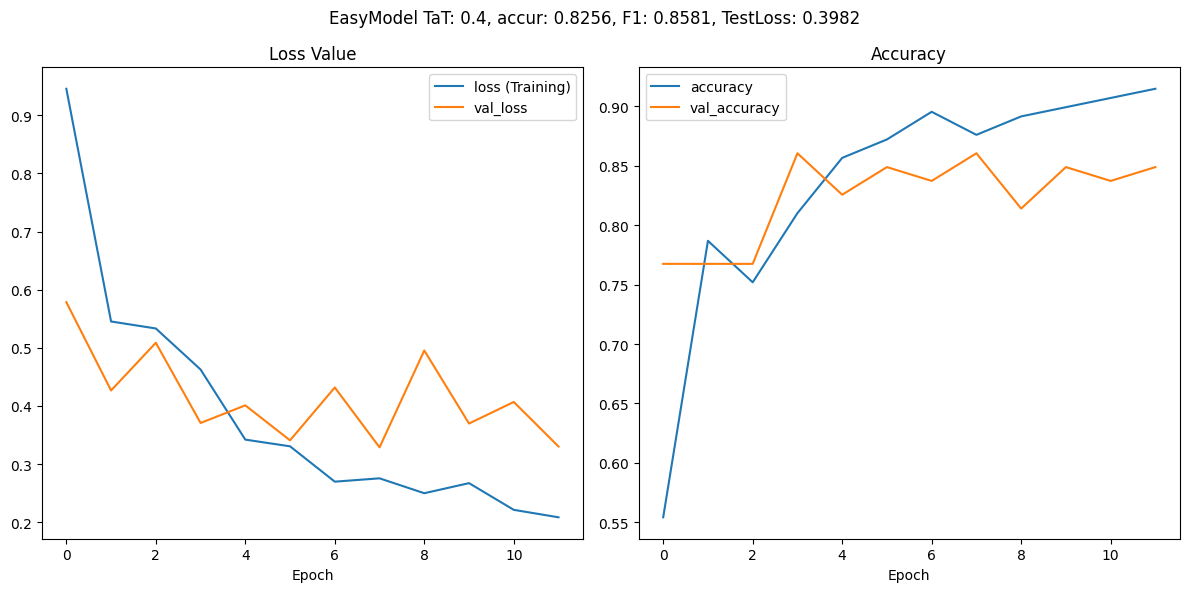

Train loss: 0.20839518308639526
Test val_loss: 0.3301330506801605
Train accuracy: 0.9147287011146545
Accuracy Score: 0.8255813953488372
F1 Score: 0.8581372549019608
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        18
         1.0       1.00      0.92      0.96        13
         2.0       0.75      0.67      0.71        27
         3.0       0.72      0.82      0.77        28

    accuracy                           0.83        86
   macro avg       0.87      0.85      0.86        86
weighted avg       0.83      0.83      0.83        86



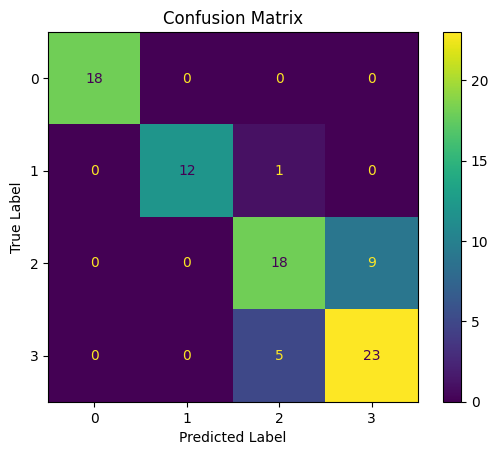

In [14]:
def build_easyModel():
    model = Sequential()
    model.add(Conv1D(filters=256, kernel_size=10, strides=4, activation='relu', input_shape=(WS_B, 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=128, kernel_size=4, activation='relu'))
    #model.add(GlobalMaxPooling1D())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(N_CLASS, activation='softmax'))
    
    return model

model = build_easyModel()
model.summary()
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#TRAIN THE MODEL
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=32, batch_size=32, validation_data=(X_val, y_val), verbose=1,callbacks=[early_stopping])

loss, accuracy = model.evaluate(X_test, y_test)

# Predict labels for test data
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1) 

f1 = f1_score(y_test, y_pred_labels, average='macro') 
accuracy = accuracy_score(y_test, y_pred_labels)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()

# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_labels))

conf_mat = confusion_matrix(y_test, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=DISP_LABELS)
disp.plot()  # You can adjust the colormap as needed
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [15]:
# model_name = "1D_LEVER_2Cnv_96"
# to_save_model(model, history, loss, accuracy, f1, model_name, y_test, y_pred_labels, build_easyModel)
# #model.save(f"{model_name}.h5")
# from tensorflow.keras.models import save_model
# save_dir = "saved_models/"
# os.makedirs(save_dir, exist_ok=True)
# model_path = os.path.join(save_dir, f"{model_name}.keras")
# save_model(model, model_path)

# 3 CONVs

/home/rluser/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_24 (Conv1D)              │ (None, 149, 256)       │        10,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_21 (MaxPooling1D) │ (None, 74, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_25 (Conv1D)              │ (None, 17, 128)        │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_22 (MaxPooling1D) │ (None, 8, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_26 (Conv1D)              │ (None, 7, 128)         │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_23 (MaxPooling1D) │ (None, 3, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 330,564 (1.26 MB)

 Trainable params: 330,564 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 198ms/step - accuracy: 0.4493 - loss: 1.2940 - val_accuracy: 0.7093 - val_loss: 0.7458
Epoch 2/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7406 - loss: 0.7497 - val_accuracy: 0.6860 - val_loss: 0.6466
Epoch 3/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6714 - loss: 0.7114 - val_accuracy: 0.7209 - val_loss: 0.6193
Epoch 4/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7451 - loss: 0.6089 - val_accuracy: 0.7209 - val_loss: 0.5203
Epoch 5/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7363 - loss: 0.5813 - val_accuracy: 0.7907 - val_loss: 0.4787
Epoch 6/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7788 - loss: 0.5696 - val_accuracy: 0.8140 - val_loss: 0.4279
Epoch 7/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7821 - loss: 0.4553 - val_accuracy: 0.7558 - val_loss: 0.4732
Epoch 8/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8184 - loss: 0.3875 - val_accuracy: 0.8140 - val_loss: 0.3750
Epoch 

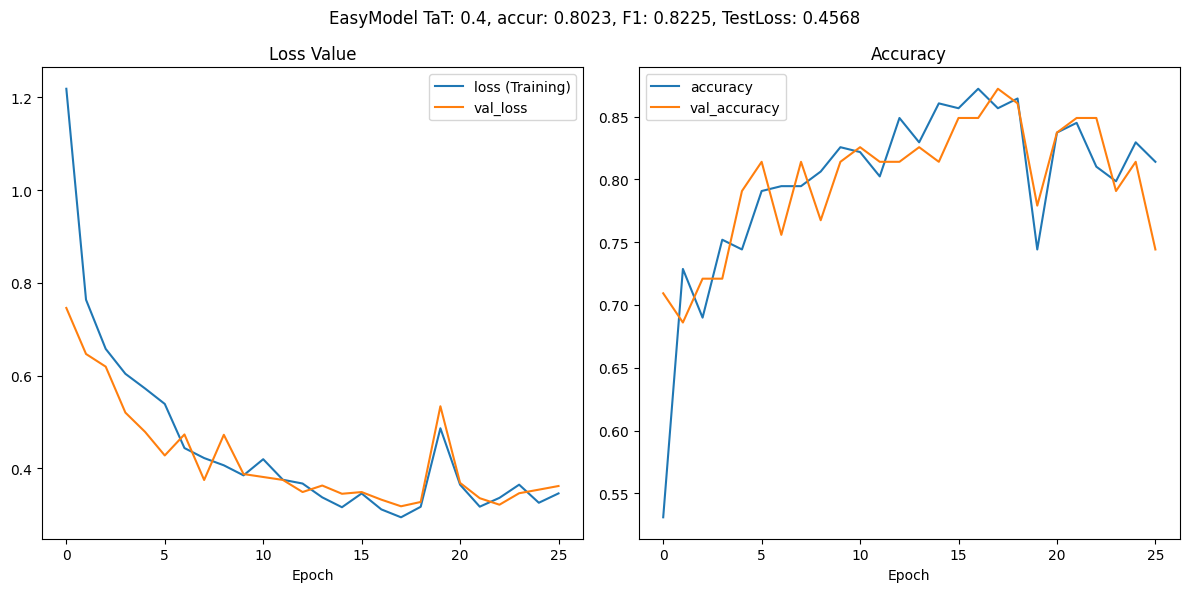

Train loss: 0.3461223542690277
Test val_loss: 0.36206895112991333
Train accuracy: 0.8139534592628479
Accuracy Score: 0.8023255813953488
F1 Score: 0.8225141713037599
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        18
         1.0       0.87      1.00      0.93        13
         2.0       0.86      0.44      0.59        27
         3.0       0.67      0.93      0.78        28

    accuracy                           0.80        86
   macro avg       0.85      0.84      0.82        86
weighted avg       0.83      0.80      0.79        86



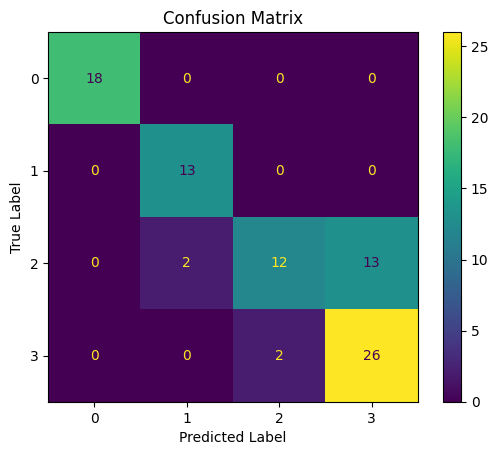

In [16]:
def build_easyModel():
    model = Sequential()
    model.add(Conv1D(256, kernel_size=40, strides=20, activation='relu', input_shape=(WS_B, 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(128, kernel_size=8, strides=4, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(128, kernel_size=2, activation='relu'))
    #model.add(GlobalMaxPooling1D())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(N_CLASS, activation='softmax'))

    return model
model = build_easyModel()
model.summary()
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#TRAIN THE MODEL
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=32, batch_size=32, validation_data=(X_val, y_val), verbose=1,callbacks=[early_stopping])

loss, accuracy = model.evaluate(X_test, y_test)

# Predict labels for test data
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1) 

f1 = f1_score(y_test, y_pred_labels, average='macro') 
accuracy = accuracy_score(y_test, y_pred_labels)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()

# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_labels))

conf_mat = confusion_matrix(y_test, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=DISP_LABELS)
disp.plot()  # You can adjust the colormap as needed
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# 4 CONVs or Still "COMPLEX"

/home/rluser/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_27 (Conv1D)              │ (None, 746, 256)       │         5,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_24 (MaxPooling1D) │ (None, 373, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_28 (Conv1D)              │ (None, 90, 256)        │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 90, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_29 (Conv1D)              │ (None, 42, 128)        │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_25 (MaxPooling1D) │ (None, 21, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_30 (Conv1D)              │ (None, 18, 128)        │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_26 (MaxPooling1D) │ (None, 9, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 64)             │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,456,196 (5.55 MB)

 Trainable params: 1,456,196 (5.55 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 234ms/step - accuracy: 0.4443 - loss: 1.2137 - val_accuracy: 0.6512 - val_loss: 0.7811
Epoch 2/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6528 - loss: 0.7801 - val_accuracy: 0.7674 - val_loss: 0.5824
Epoch 3/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8329 - loss: 0.4669 - val_accuracy: 0.7326 - val_loss: 0.5065
Epoch 4/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7113 - loss: 0.5862 - val_accuracy: 0.8140 - val_loss: 0.4617
Epoch 5/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7910 - loss: 0.5016 - val_accuracy: 0.7907 - val_loss: 0.5564
Epoch 6/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7673 - loss: 0.5253 - val_accuracy: 0.7326 - val_loss: 0.5541
Epoch 7/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8111 - loss: 0.4293 - val_accuracy: 0.8140 - val_loss: 0.4714
Epoch 8/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8486 - loss: 0.4155 - val_accuracy: 0.8256 - val_loss: 0.4224

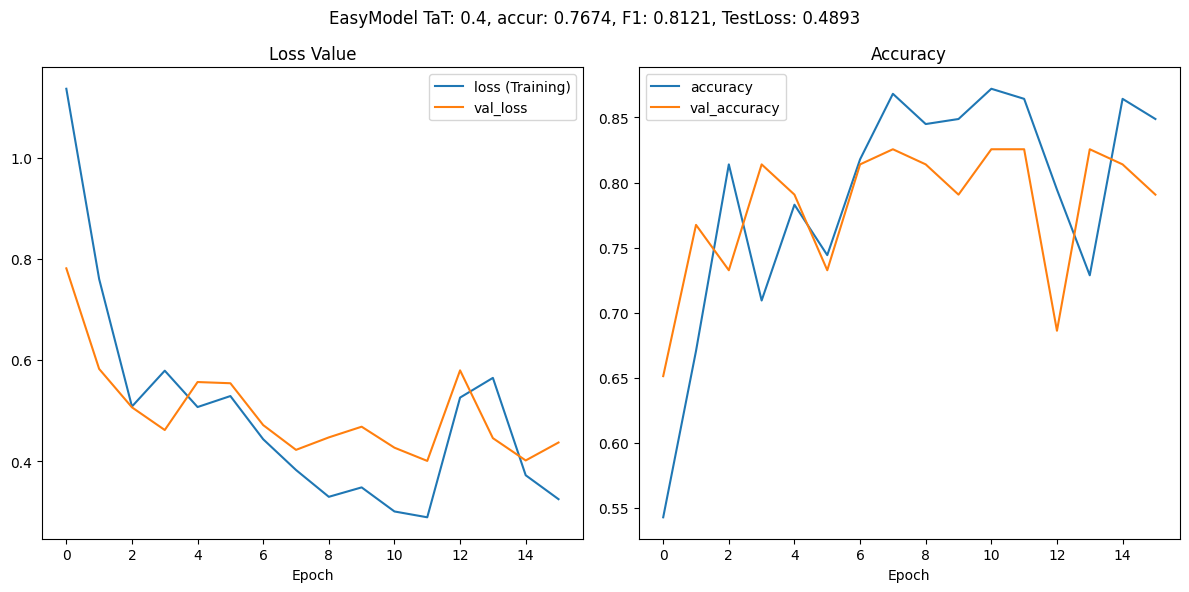

Train loss: 0.3250208795070648
Test val_loss: 0.4369752109050751
Train accuracy: 0.8488371968269348
Accuracy Score: 0.7674418604651163
F1 Score: 0.8121311475409836
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        18
         1.0       1.00      0.92      0.96        13
         2.0       0.65      0.56      0.60        27
         3.0       0.64      0.75      0.69        28

    accuracy                           0.77        86
   macro avg       0.82      0.81      0.81        86
weighted avg       0.77      0.77      0.77        86



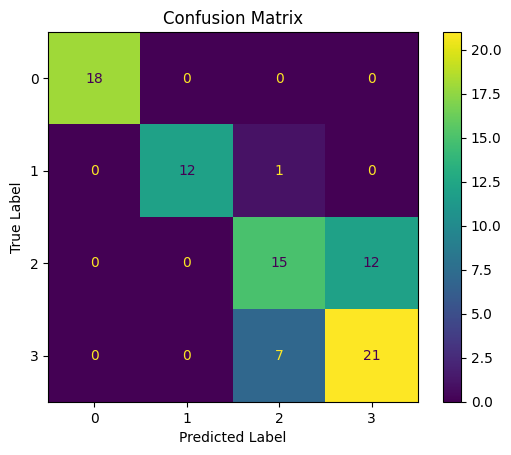

In [17]:
def build_easyModel():
    model = Sequential()
    
    model.add(Conv1D(filters=256, kernel_size=20, strides=4, activation='relu', input_shape=(WS_B, 1)))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Conv1D(filters=256, kernel_size=16, strides=4, activation='relu')) #LeakyReLU(alpha=0.001)
    model.add(Dropout(rate=0.1))
    
    model.add(Conv1D(filters=128, kernel_size=8, strides=2, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Conv1D(filters=128, kernel_size=4, activation='relu'))
    #model.add(GlobalMaxPooling1D())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(N_CLASS, activation='softmax'))
    return model

model = build_easyModel()
model.summary()
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#TRAIN THE MODEL
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=32, batch_size=32, validation_data=(X_val, y_val), verbose=1,callbacks=[early_stopping])

loss, accuracy = model.evaluate(X_test, y_test)

# Predict labels for test data
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1) 

f1 = f1_score(y_test, y_pred_labels, average='macro') 
accuracy = accuracy_score(y_test, y_pred_labels)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()

# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_labels))

conf_mat = confusion_matrix(y_test, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=DISP_LABELS)
disp.plot()  # You can adjust the colormap as needed
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# 5 CONVS